In [1]:
import numpy as np 
import pandas as pd
import datetime as dt 
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
from warnings import filterwarnings
from pandas.tseries.offsets import YearEnd
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from tqdm import tqdm
from matplotlib import gridspec

filterwarnings('ignore')

In [10]:
#df      = pd.read_pickle('./DATA/kospi_adj_close.pkl').astype(float)
#df      = pd.read_pickle('./DATA/kospi_price_tmp.pkl').astype(float).loc['1982-03':]
#df_cap  = pd.read_pickle('./DATA/kospi_capital.pkl').astype(float)
#df_eq   = pd.read_pickle('./DATA/kospi_total_asset.pkl').astype(float)
df_ret = pd.read_pickle('./DATA/real_ret.pkl')

df_cap  = pd.read_pickle('./DATA/real_cap.pkl')
#df_eq   = pd.read_pickle('./DATA/kospi_total_asset_tmp.pkl').astype(float)
df_eq = pd.read_pickle('./DATA/BE.pkl')
#df_eq = pd.read_pickle('./DATA/real_BE.pkl')

df_info = pd.read_pickle('./DATA/real_kospi_info.pkl')
df_code = pd.read_pickle('./DATA/real_kospi_code.pkl')

rf = pd.read_csv('./DATA/CD91.csv', index_col=0, parse_dates=True).apply(lambda x : x/100).resample('m').last()

In [11]:
def cal_mdd (ret_df):
    
    cum = ((ret_df+1).cumprod()-1)
    p = np.maximum.accumulate(cum)
    dd = (cum-p)/p
    return dd

#df_close_daily = df.copy()
'''코스피만 남기기'''
#df_close_daily = df_close_daily * df_info.replace('유가증권시장', 1).replace('비상장', np.NaN).replace('코스닥', np.NaN).replace('K-OTC', np.NaN).astype(float)
'''페니스톡 지우기'''
def filtering_penny (series):
    
    return np.where(series > 1000, series, np.NaN)

#df_close_daily = df_close_daily.apply(lambda x: filtering_penny(x), axis=0)

#mom_ret     = df_close_daily.resample('m').last().shift(1).pct_change(11).iloc[12:-1].replace(0, np.NaN)
#monthly_ret = df_close_daily.resample('m').last().pct_change().iloc[1:-1].replace(0, np.NaN)

'''시장, 업종 필터링'''
df_ret = df_ret * df_info.replace('유가증권시장', 1).replace('비상장', np.NaN).replace('코스닥', np.NaN).replace('K-OTC', np.NaN).astype(float)
df_ret = df_ret * pd.DataFrame(np.where(df_code == 'K', 0, 1.0), index=df_code.index, columns=df_code.columns)

df_eq = df_eq * df_info.replace('유가증권시장', 1).replace('비상장', np.NaN).replace('코스닥', np.NaN).replace('K-OTC', np.NaN).astype(float)
df_eq = df_eq * pd.DataFrame(np.where(df_code == 'K', 0, 1.0), index=df_code.index, columns=df_code.columns)

df_cap = df_cap * df_info.replace('유가증권시장', 1).replace('비상장', np.NaN).replace('코스닥', np.NaN).replace('K-OTC', np.NaN).astype(float)
df_cap = df_cap * pd.DataFrame(np.where(df_code == 'K', 0, 1.0), index=df_code.index, columns=df_code.columns)




#mom_ret     = df_ret.shift(1).r(11).iloc[12:-1].replace(0, np.NaN)
#monthly_ret = df_ret.pct_change().iloc[1:-1].replace(0, np.NaN)

mom_ret = df_ret.shift(1).rolling(11).apply(lambda x: (1+x).prod()-1)
monthly_ret = df_ret

In [12]:
pnl_ret_list  = []
ivst_idx_list = []
long_tick_list = []
short_tick_list = []
s_ret_list = []
l_ret_list = []

for num in range(len(mom_ret)-1):
    series = mom_ret.iloc[num]

    date_idx = series.name
    ivst_idx = monthly_ret.index[np.where(monthly_ret.index==date_idx)[0][0] + 1]

    long_tick = series[series > series.quantile(0.9)].index.to_list()
    short_tick = series[series < series.quantile(0.1)].index.to_list()
    #short_tick = series[series < series.quantile(0.2)].index.to_list()

    long_ret = monthly_ret.loc[ivst_idx, long_tick].mean()
    short_ret = monthly_ret.loc[ivst_idx, short_tick].mean()
        
    pnl_ret = monthly_ret.loc[ivst_idx, long_tick].mean() - monthly_ret.loc[ivst_idx, short_tick].mean()
        
    pnl_ret_list.append(pnl_ret)
    ivst_idx_list.append(ivst_idx)
    long_tick_list.append(long_tick)
    short_tick_list.append(short_tick)
    s_ret_list.append(short_ret)
    l_ret_list.append(long_ret)
    

mom_pnl = pd.DataFrame(index=ivst_idx_list, \
                       data=pd.DataFrame([pnl_ret_list, long_tick_list, short_tick_list, s_ret_list, l_ret_list]).T.values,\
                       columns=['mom_pnl', 'long_idx', 'short_idx', 's_ret', 'l_ret'])

<AxesSubplot:>

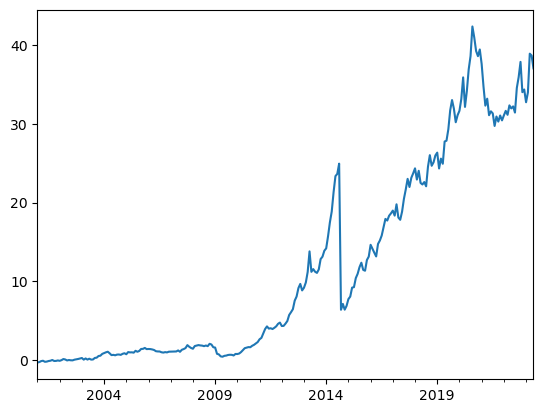

In [13]:
((mom_pnl.loc['2001-01-01':].iloc[:,0]+1).cumprod() -1).plot()